In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from WISE_tools import plot_confusion_matrix

%matplotlib inline

# Reading in KernelPCA transformed data

In [5]:
X_r = pd.read_csv('transformed_features.csv')
len(X_r)

2948

# Classification algorithms are great at drawing horizontal/vertical lines in feature-space, so we're going to want to make things as easy as possible here, and use PCA to pull out features of maximum variance. This will also let us construct colors that span pretty large wavelength baselines through linear combinations.

In [9]:
X = X_r[[f'C_{i}' for i in range(9)]]
y = X_r['Class']
X,y

(            C_0       C_1       C_2       C_3       C_4       C_5       C_6  \
 0    -17.366111 -4.636066  2.675294  1.023494 -0.003769 -1.406514 -1.019733   
 1    -18.698214 -5.290157  1.793734  0.668162  0.339390 -2.016091 -1.231599   
 2    -19.541386 -4.879721  1.546540  0.778442  0.363128 -2.568468 -1.238928   
 3    -17.986617 -4.826753  2.075737  0.821964  0.172704 -1.688011 -1.063407   
 4    -18.658740 -3.874783  1.049600  0.352722  0.356343 -2.190932 -0.759456   
 ...         ...       ...       ...       ...       ...       ...       ...   
 2943   7.582379 -4.977833 -4.152600 -0.678592 -1.418020  2.136261 -1.205758   
 2944   1.147536 -3.001643 -3.792238 -0.577875  0.321956  2.439715 -0.882536   
 2945   4.235616 -8.255695 -4.615321 -0.063396 -1.167107  2.887200 -0.844208   
 2946   1.751283 -5.632459 -5.957359  0.152129 -3.425167  2.314371 -2.190799   
 2947   8.151756 -9.795877 -6.330807 -1.147562 -1.537175  2.913488 -1.182493   
 
            C_7       C_8  
 0     0.0

# Decision Tree trained on adjacent colors, plus G and W1 absolute magnitudes

/Users/carina/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Decision Tree with max_depth set to :
7
and max_features set to :
None


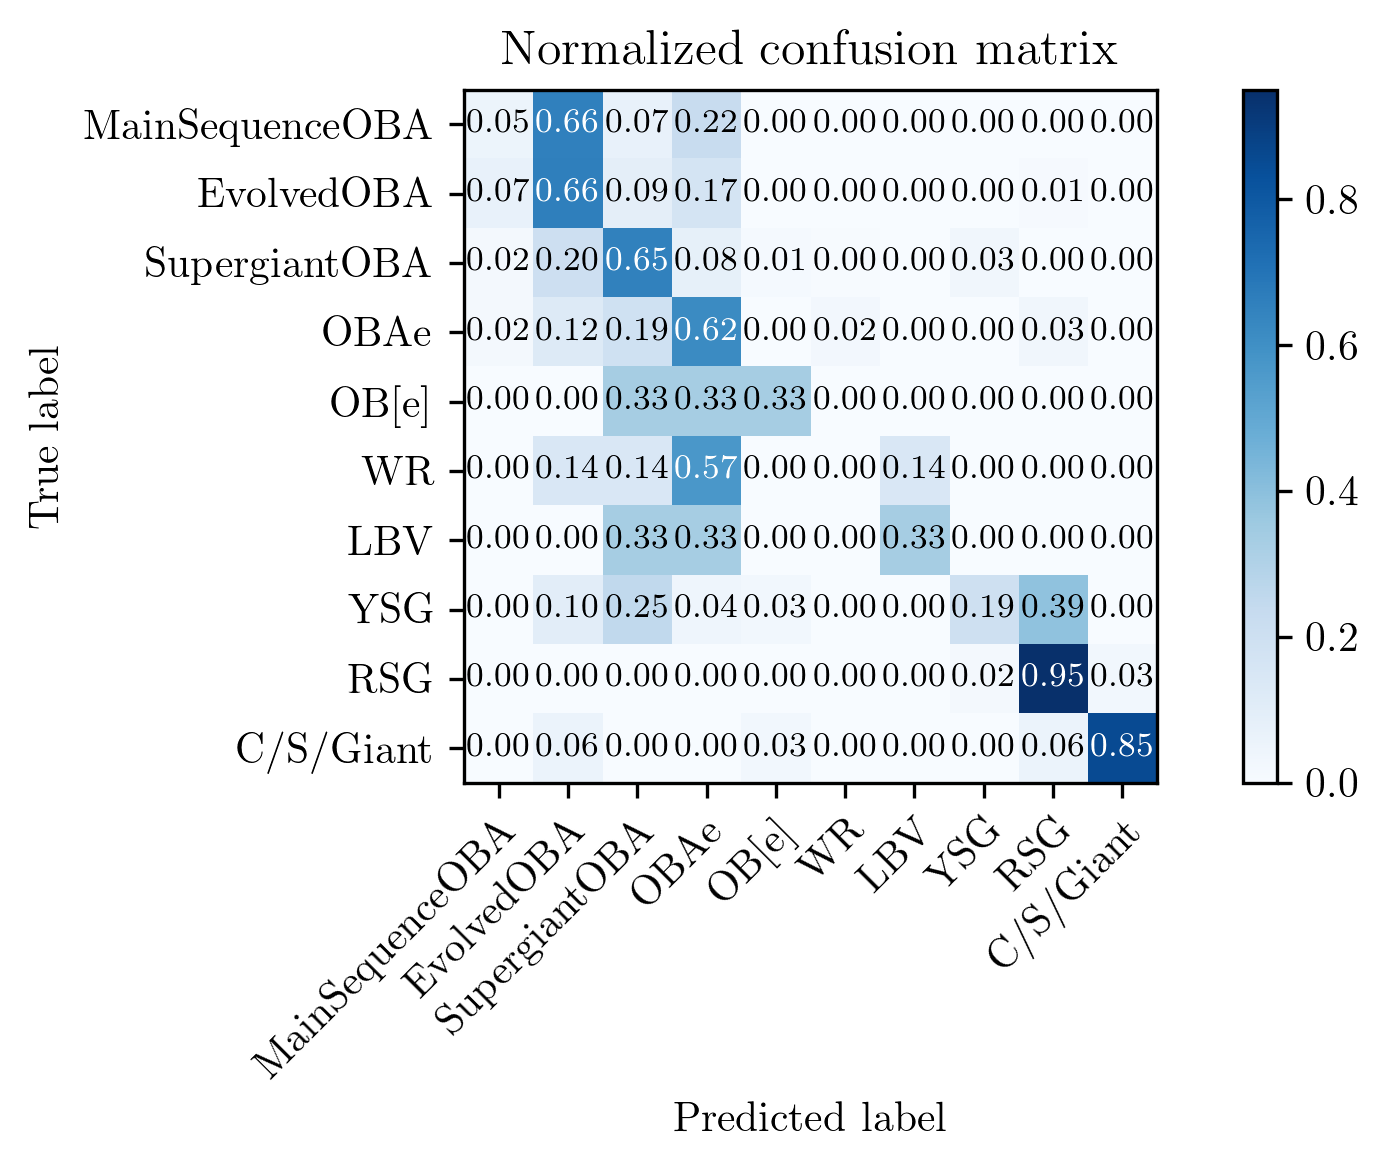

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': np.arange(2,15,1),'max_features': ['sqrt','log2',None]}
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=4)
grid.fit(X_train, y_train)
    
tree = grid.best_estimator_
max_depth = tree.max_depth
max_features = tree.max_features
print('Decision Tree with max_depth set to :')
print(max_depth)
print('and max_features set to :')
print(max_features)
tree.fit(X_train,y_train)
y_check_DT = tree.predict(X_test)

classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant']

fig,ax = plot_confusion_matrix(y_test, y_check_DT, classes=classes, normalize=True);
fig.dpi = 300
plt.tight_layout()
plt.savefig('confusion_DT.pdf');

# Random Forest trained on adjacent colors and G/W1 absolute mags

Random Forrest with max_depth set to :
10
max_features set to :
log2
and n_estimators set to :
120


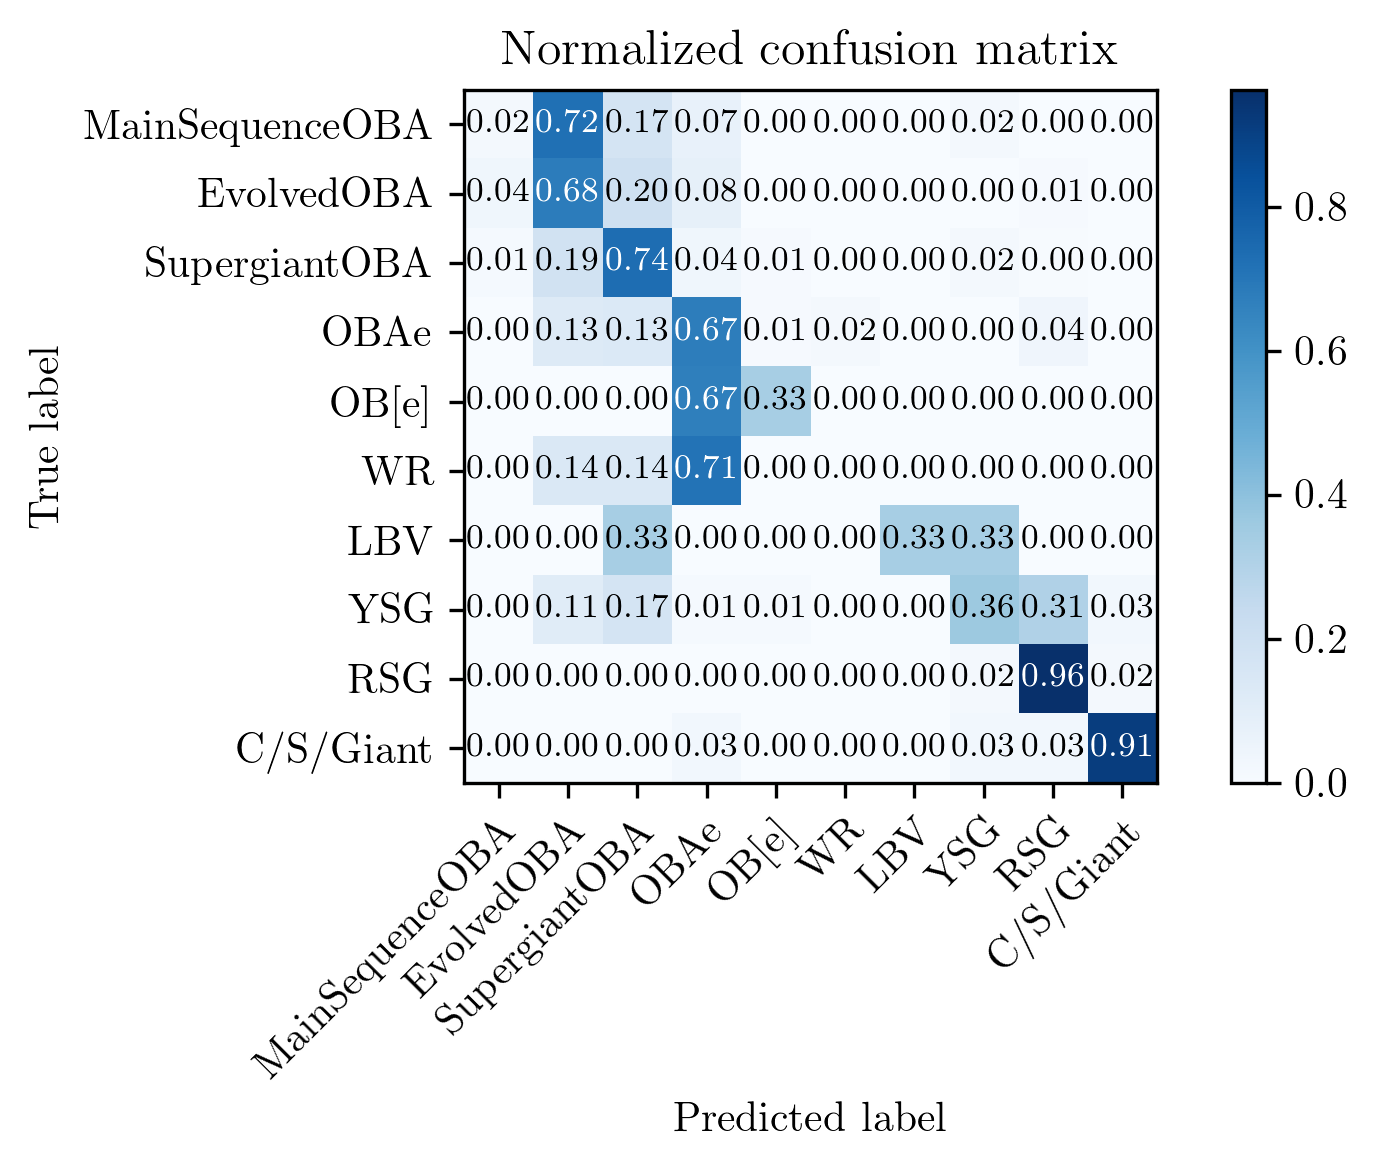

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(70,140,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)
grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,y_train)
y_check_RF = forrest.predict(X_test)

fig,ax = plot_confusion_matrix(y_test, y_check_RF,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_RF.pdf');

# Gaussian Mixture Model on same (idea for later: use AIC or BIC to get the ideal number of Gaussians to describe the data. Then look at the SpT of each Gaussian to see if we can learn anything/improve our classifications)

Gaussian Mixture with covariance_type set to :
full


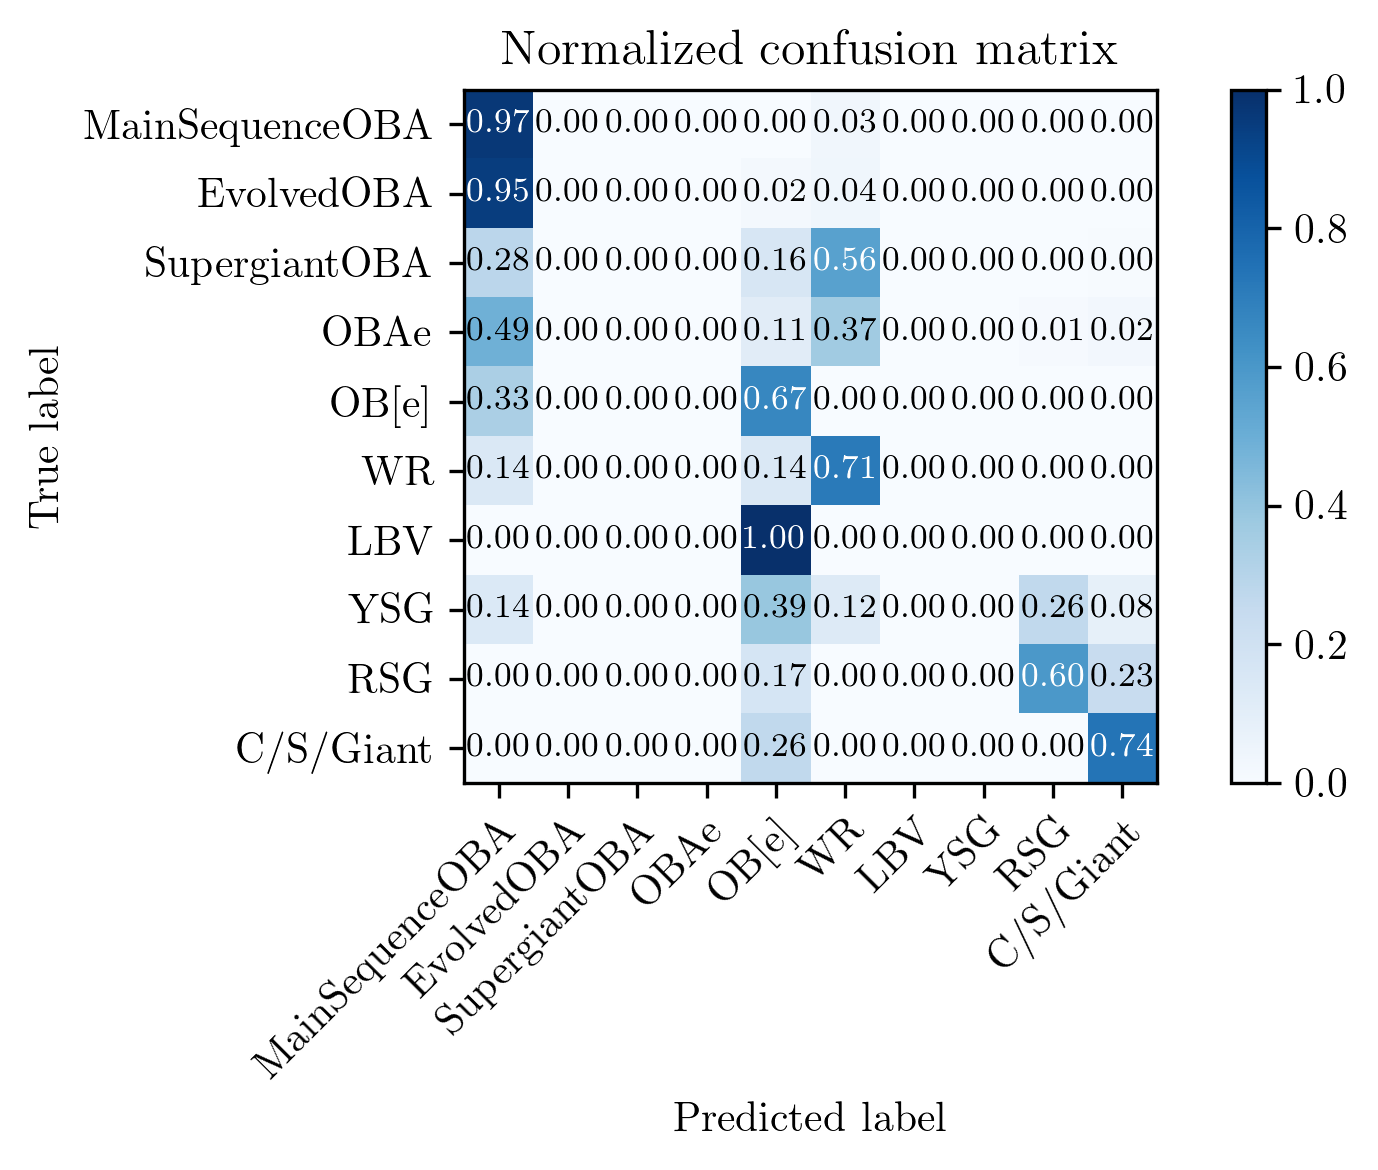

In [14]:
unique_class = np.unique(y)
real_class = {i:cl for i,cl in enumerate(unique_class)}
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'covariance_type': ['full','tied','diag','spherical']}

grid = GridSearchCV(GaussianMixture(n_components=(len(unique_class)),
                                    means_init=[X_train[y_train == c].mean(axis=0) 
                                                for c in unique_class]),
                    params, cv=4)
grid.fit(X_train.values)

gm = grid.best_estimator_
covar = gm.covariance_type
print('Gaussian Mixture with covariance_type set to :')
print(covar)
gm.fit(X_train)
y_check_GM = [real_class[i] for i in gm.predict(X_test)]

fig,ax = plot_confusion_matrix(y_test, y_check_GM,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_GM.pdf');

# Random Forest trained on (transformed) colors and mags, plus W1, W2, and W1-W2 variability metrics

In [27]:
#Let's throw out classes that we don't care about/aren't specific enough, plus binaries
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
training_indices = np.array([c not in np.array(['Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

#Our features will be color and G/W1 magnitude.
X_var = training_data[['W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes',
       'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt','W2_stdDt','W1-W2_Nzeroes', 
       'W1-W2_meanDt', 'W1-W2_stdDt']]
X_var = pd.concat([X,X_var],axis=1).reset_index(drop=True)
y_var = y.copy().reset_index(drop=True)

X_var

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,W1chi2red,...,W1-W2_EWM,W1_Nzeroes,W1_meanDt,W1_stdDt,W2_Nzeroes,W2_meanDt,W2_stdDt,W1-W2_Nzeroes,W1-W2_meanDt,W1-W2_stdDt
0,-17.366111,-4.636066,2.675294,1.023494,-0.003769,-1.406514,-1.019733,0.002271,-0.882627,1.359010,...,0.640184,1,1757.970382,0.000000,0,0.000000,0.000000,1,1811.052969,0.000000
1,-18.698214,-5.290157,1.793734,0.668162,0.339390,-2.016091,-1.231599,0.210665,-0.578463,0.487878,...,0.966334,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
2,-19.541386,-4.879721,1.546540,0.778442,0.363128,-2.568468,-1.238928,0.443714,-0.685057,1.295271,...,0.731055,3,743.481912,432.947298,3,329.521069,76.562698,2,766.136486,361.443423
3,-17.986617,-4.826753,2.075737,0.821964,0.172704,-1.688011,-1.063407,0.121498,-0.691543,2.532005,...,0.796283,1,577.211942,0.000000,5,585.854687,189.568305,5,478.437706,178.441935
4,-18.658740,-3.874783,1.049600,0.352722,0.356343,-2.190932,-0.759456,0.512051,-0.489232,2.284423,...,0.727922,0,0.000000,0.000000,1,1324.741088,0.000000,1,1658.264138,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,7.582379,-4.977833,-4.152600,-0.678592,-1.418020,2.136261,-1.205758,2.169546,0.079865,13.589074,...,1.947283,3,637.896058,174.217104,3,592.637034,151.044299,4,506.602191,112.054510
2944,1.147536,-3.001643,-3.792238,-0.577875,0.321956,2.439715,-0.882536,1.448385,0.526560,63.684912,...,2.178113,3,672.975890,162.180335,3,666.143648,208.187298,3,655.895284,152.281054
2945,4.235616,-8.255695,-4.615321,-0.063396,-1.167107,2.887200,-0.844208,2.619452,-0.104813,58.489304,...,1.216553,7,292.153772,151.983856,7,298.864808,173.912400,8,323.751567,168.238169
2946,1.751283,-5.632459,-5.957359,0.152129,-3.425167,2.314371,-2.190799,1.976649,0.630762,3.079039,...,1.023234,2,835.747127,13.954961,1,2037.424351,0.000000,1,1907.178045,0.000000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_var, y_var, test_size=0.3, random_state=np.random.randint(1))
params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,y_train)
y_check_RF_var = forrest.predict(X_test)

fig,ax = plot_confusion_matrix(y_test, y_check_RF_var,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_variability_RF.pdf');

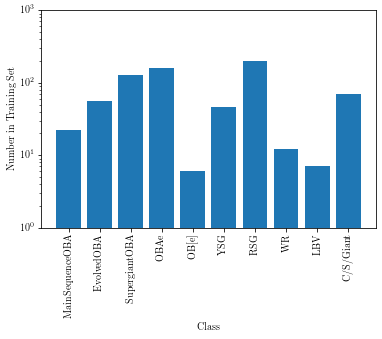

In [23]:
#How many of each class are there in the training and test set?
num_input = []
test_classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','C/S/Giant']
for test_class in test_classes:
    num = len(y_train[y_train == test_class])
    num_input.append(num)
plt.bar(np.arange(len(test_classes)),num_input)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical');
plt.xlabel('Class')
plt.ylabel('Number in Training Set')
plt.ylim(1,1000);

(1, 300)

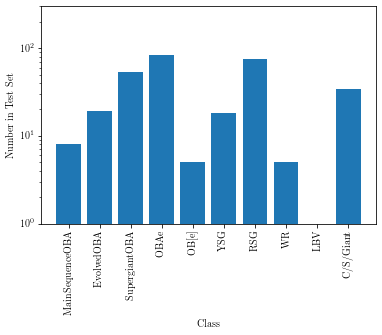

In [24]:
#How many of each class are there in the training and test set?
num_input = []
for test_class in test_classes:
    num = len(y_test[y_test == test_class])
    num_input.append(num)
plt.bar(np.arange(len(test_classes)),num_input)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical');
plt.xlabel('Class')
plt.ylabel('Number in Test Set')
plt.ylim(0.1,300)

(1, 5000)

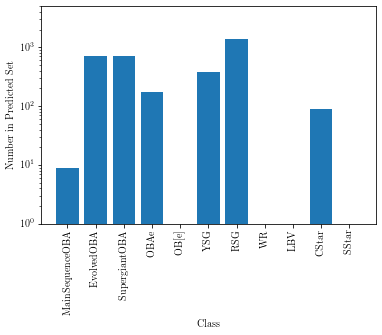

In [16]:
unknown_indices = [c in np.array(['Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=-999)
unknowns_data = unknowns[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                          'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM',
                          'W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 
                          'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
unknown_classes = forrest.predict(unknowns_data)
num_output = []
for pred_class in test_classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
plt.bar(np.arange(len(test_classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Number in Predicted Set')
plt.ylim(1,5000)

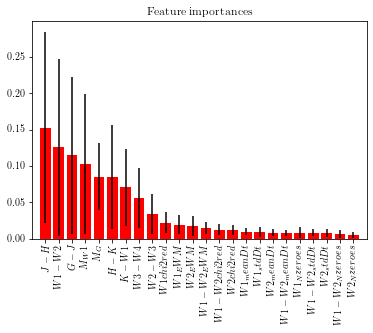

In [17]:
importances = forrest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forrest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.title("Feature importances")
plt.bar(np.arange(len(X.columns[indices])), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(ticks=np.arange(len(X.columns[indices])),labels=['${0}$'.format(name) for name in X.columns[indices]],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.savefig('feature_importance_RF.pdf')

# Random Forest trained on the SEDs (extinction corrected in G)

In [18]:
X_mags = training_data[['M_G','M_W1']]
dist_mod = []
for i,row in training_data.iterrows():
    if row['Galaxy'] == 'Milky Way':
        dist_mod.append(5.0*np.log10(row['r_est']) - 5.0)
    elif row['Galaxy'] == 'LMC':
        dist_mod.append(18.52)
    elif row['Galaxy'] == 'SMC':
        dist_mod.append(19.05)
X_mags.insert(1,'M_J',training_data['Jmag'].values - dist_mod)
X_mags.insert(2,'M_H',training_data['Hmag'].values - dist_mod)
X_mags.insert(3,'M_K',training_data['Kmag'].values - dist_mod)
X_mags.insert(5,'M_W2',training_data['w2mpro'].values - dist_mod)
X_mags.insert(6,'M_W3',training_data['w3mpro'].values - dist_mod)
X_mags.insert(7,'M_W4',training_data['w4mpro'].values - dist_mod)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)
grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,y_train)
y_check_RF_mags = forrest.predict(X_test)

Random Forrest with max_depth set to :
10
max_features set to :
sqrt
and n_estimators set to :
90


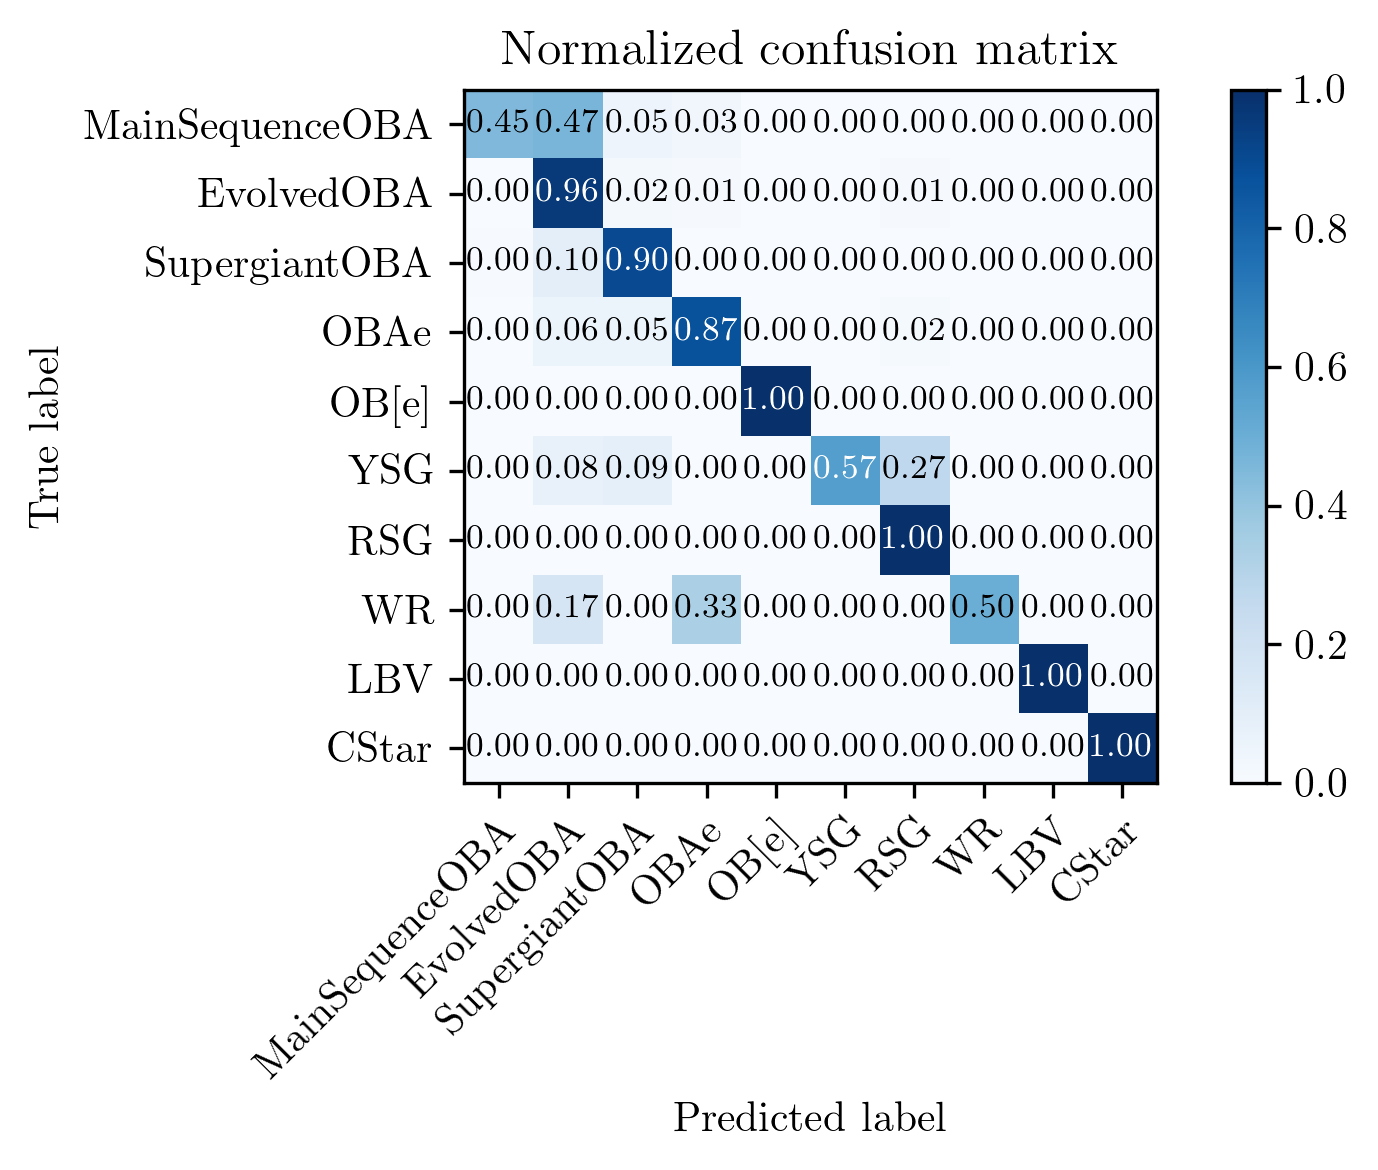

In [20]:
fig,ax = plot_confusion_matrix(y_test, y_check_RF_mags,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_mags.pdf');

# SED + Variability?

In [21]:
X_mags[['W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes',
   'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 
   'W1-W2_meanDt', 'W1-W2_stdDt']] = training_data[[
   'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes',
   'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 
   'W1-W2_meanDt', 'W1-W2_stdDt']]

X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,y_train)
y_check_magvar = forrest.predict(X_test)

/Users/carina/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Random Forrest with max_depth set to :
9
max_features set to :
log2
and n_estimators set to :
100


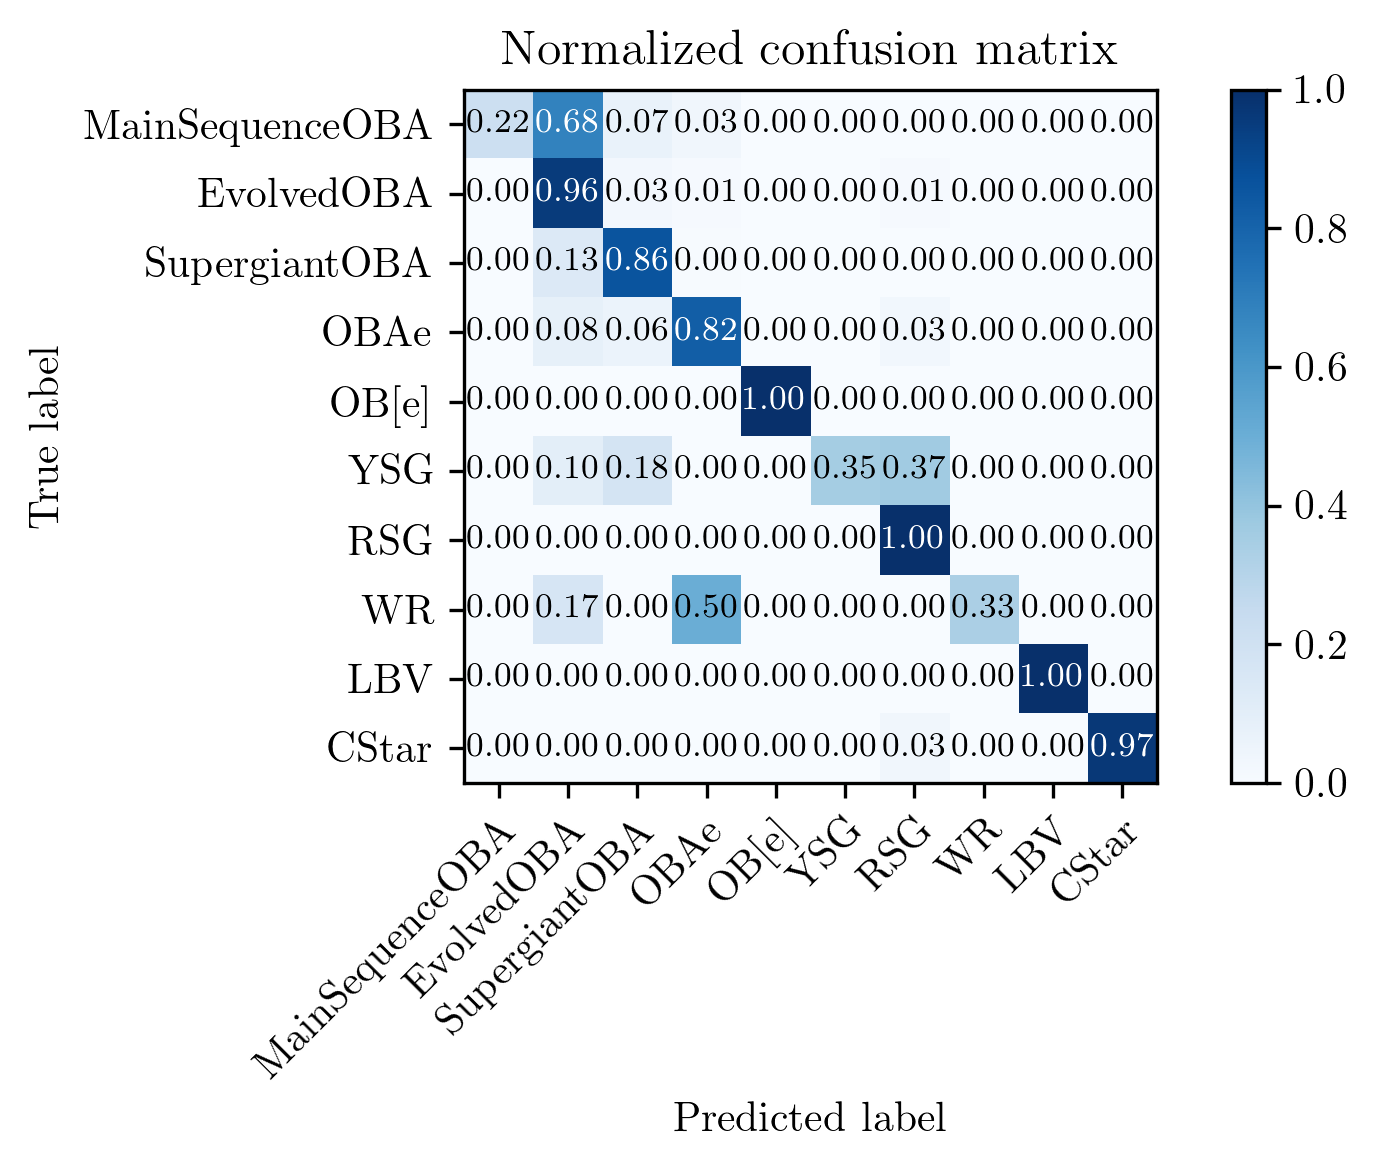

In [22]:
fig,ax = plot_confusion_matrix(y_test, y_check_magvar,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_magvar.pdf');

# SED + Variability + Numeric Metallicity Code?

In [23]:
num_met = []
for i,row in training_data.iterrows():
    if row['Galaxy'] == 'Milky Way':
        num_met.append(2)
    elif row['Galaxy'] == 'LMC':
        num_met.append(1)
    elif row['Galaxy'] == 'SMC':
        num_met.append(0)
X_mags.insert(8,'Numerical Metallicity',num_met)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,train)
y_check_magvarmet = forrest.predict(X_test)

Random Forrest with max_depth set to :
10
max_features set to :
log2
and n_estimators set to :
40


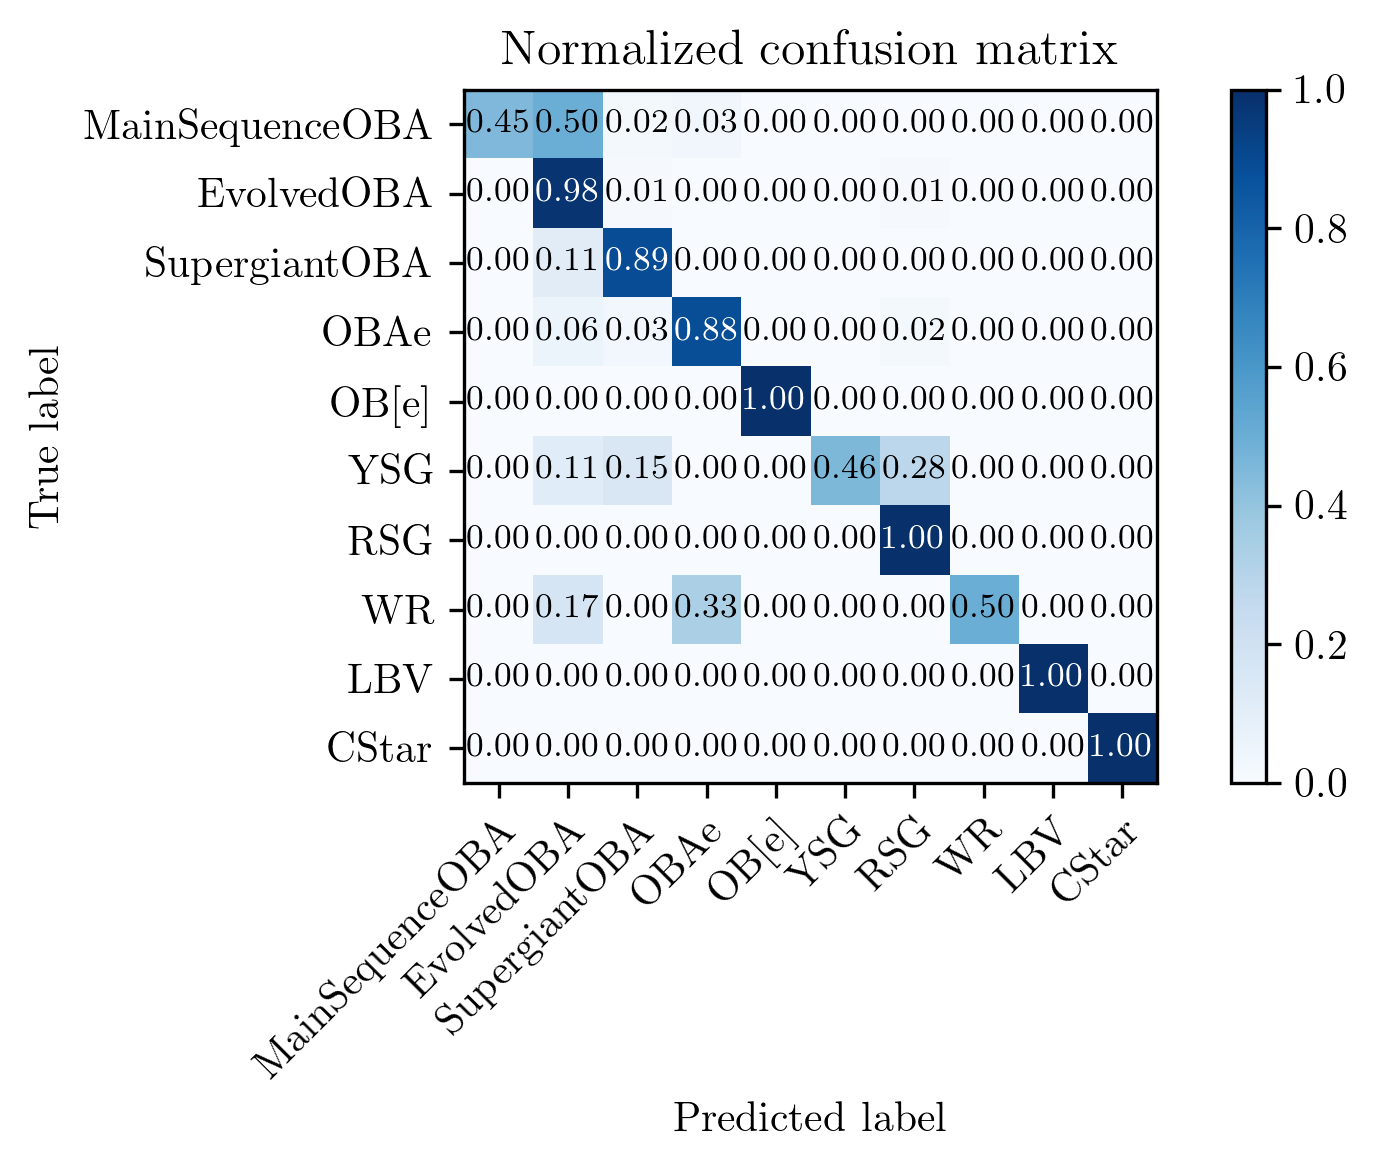

In [26]:
fig,ax = plot_confusion_matrix(y_test, y_check_magvarmet,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_magvarmet.pdf');

# Color, M_G, M_W1, variability, and metallicity?

In [27]:
X_all = training_data[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                      'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM',
                       'W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 
                       'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']] 

X_all.insert(X_all.values.shape[1],'Numerical Metallicity',num_met)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_train,y_train)
y_check_all = forrest.predict(X_test)

Random Forrest with max_depth set to :
8
max_features set to :
sqrt
and n_estimators set to :
40


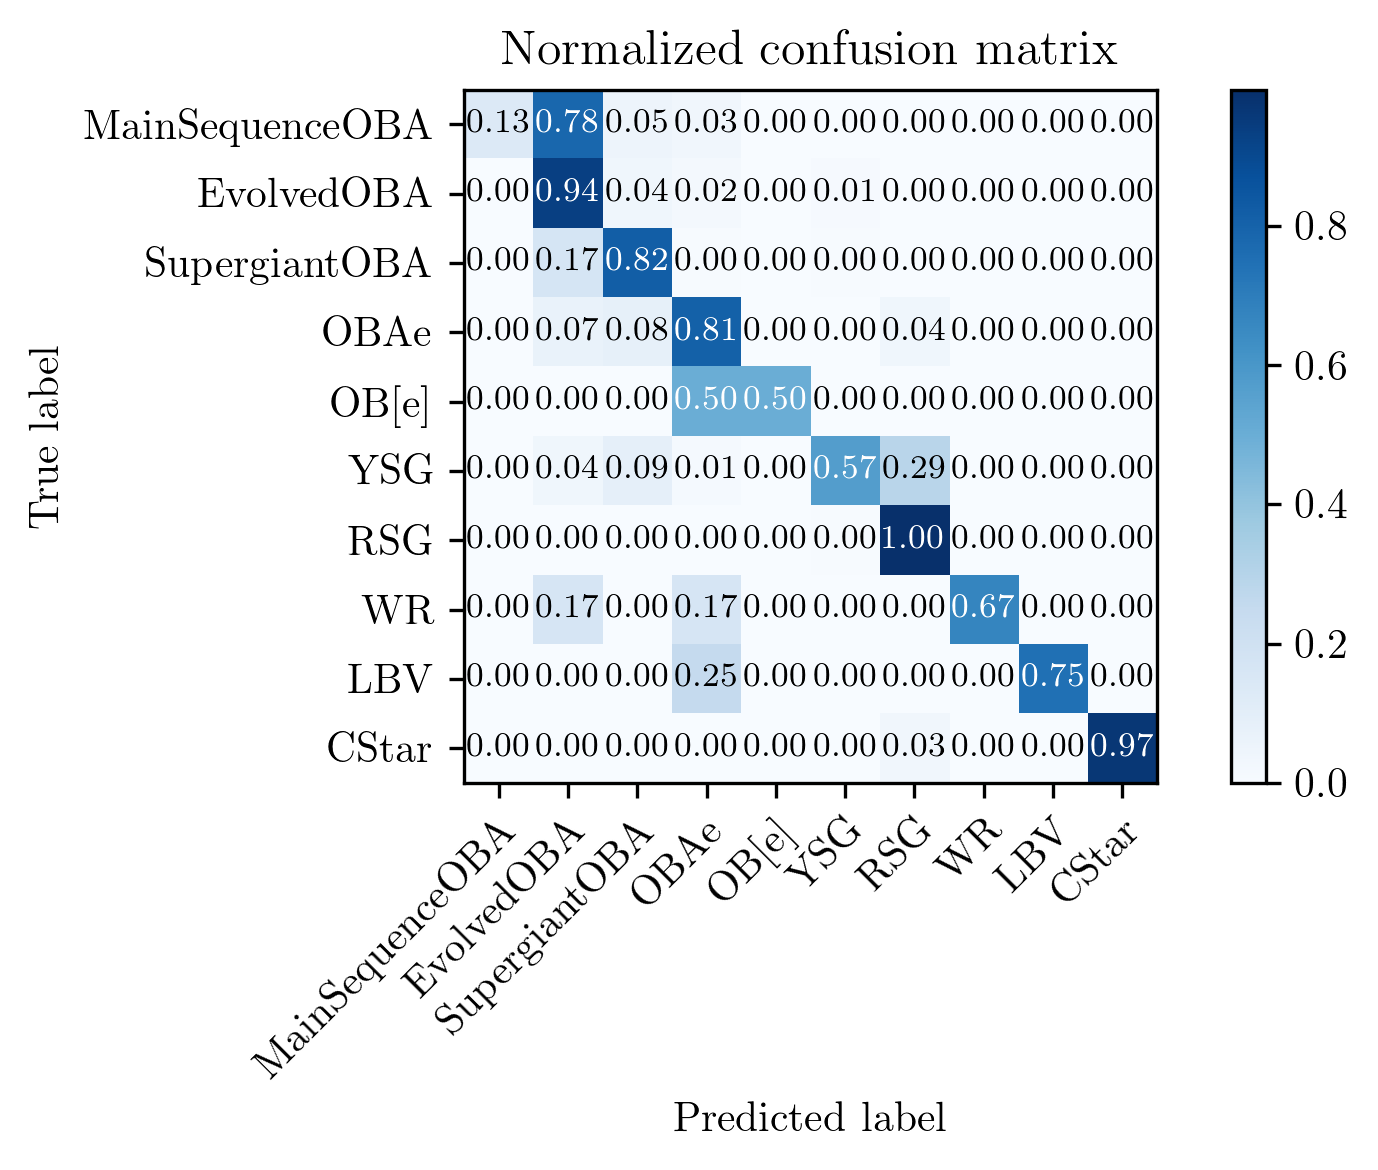

In [28]:
fig,ax = plot_confusion_matrix(y_test, y_check_all,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_colvarmet.pdf');

# Let's try the whole thing on the Coarse labels that we assigned

In [ ]:
training_indices_c = np.array([c != 'Unknown/Candidate' for c in joined['CoarseClass'].values]) & np.array([i == 0 for i in joined['IsBinary'].values])

training_data_c = joined[training_indices_c].fillna(0).reset_index()
X_c = training_data_c[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1']]
y_c = training_data_c['CoarseClass']
,len(y_c)

# Let's do some Feature Pruning! Woof.

In [ ]:
#Absolute Magnitudes and Colors
X_all = training_data[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1']]
dist_mod = []
for i,row in training_data.iterrows():
    if row['Galaxy'] == 'Milky Way':
        dist_mod.append(5.0*np.log10(row['r_est']) - 5.0)
    elif row['Galaxy'] == 'LMC':
        dist_mod.append(18.52)
    elif row['Galaxy'] == 'SMC':
        dist_mod.append(19.05)
X_all.insert(1,'M_J',training_data['Jmag'].values - dist_mod)
X_all.insert(2,'M_H',training_data['Hmag'].values - dist_mod)
X_all.insert(3,'M_K',training_data['Kmag'].values - dist_mod)
X_all.insert(5,'M_W2',training_data['w2mpro'].values - dist_mod)
X_all.insert(6,'M_W3',training_data['w3mpro'].values - dist_mod)
X_all.insert(7,'M_W4',training_data['w4mpro'].values - dist_mod)

#Metallicity
X_all.insert(X_all.values.shape[1],'Numerical Metallicity',num_met)

#Variability
X_mags[['W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes',
   'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 
   'W1-W2_meanDt', 'W1-W2_stdDt']] = training_data[[
   'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes',
   'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 
   'W1-W2_meanDt', 'W1-W2_stdDt']]